# Détectez les bad buzz grace au Deeplearning

In [1]:
import warnings
warnings.simplefilter(action='ignore')
# basic libs
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import unidecode
import gc
# text preprocessing
import nltk
import gensim
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
# simple random forest regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# deeplearning
import tensorflow as tf

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)


### Text preproccessing

On commence par tokéniser le texte (on ne garde que les mots, en supprimant la pontuation, les liens, les nombres ...).
On retire également les "stop-words", c'est-à-dire tous les articles, déterminants, pronoms et mots de liaison.
On applique ensuite deux traitements différents séparément pour comparer leurs performances: la lemmatisation (qui garde seulement la forme canonique des mots, par exemple le féminin singulier) et le stemming (qui garde uniquement le radical des mots). 

In [2]:
done_preprocessing = 1

n_words = 5000 # warning: must be higher later

test_size = 100000
val_size = 100000

lbls = ['Negative', '', '', '', 'Positive']

if not done_preprocessing:
    train_df = pd.read_csv('./data/dataset.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding='latin-1')
    train_df = train_df[['target', 'text']]
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stop_words = list(nltk.corpus.stopwords.words('english'))
    
    def clean_up(text):
        text = unidecode.unidecode(''.join(c for c in text if not c.isdigit()).replace('\n', '').lower())
        text = text.split()
        for exclude in ['@', '/']:
            text = [w for w in text if not exclude in w]
        text = ' '.join(text)
        tokens = tokenizer.tokenize(text)
        tokens = [w for w in tokens if not w in stop_words and len(w) > 1]
        return " ".join(tokens)
    
    def update_target(tgt):
        return 1 if tgt else 0
    
    train_df["target"] = train_df["target"].apply(update_target)
    
    train_df["text"] = train_df["text"].apply(clean_up)
    
    train_df = train_df[train_df['text'] != ""]
    
    train_df = train_df.sample(frac=1)
    
    train_df.to_csv('./data/preprocessed.csv', index=False)

In [3]:
if not done_preprocessing:
    
    train_df = pd.read_csv('./data/preprocessed.csv')
    
    stemmer = EnglishStemmer()
    lemmatizer = WordNetLemmatizer()

    def stem(text):
        return [w for w in [stemmer.stem(w2) for w2 in text]if len(w) > 1]

    def lem(text):
        return [w for w in [lemmatizer.lemmatize(w2) for w2 in text]if len(w) > 1]
    
    # vanilla
    train_df["text"] = train_df["text"].apply(lambda x: x.split())
    v_dictionary = gensim.corpora.Dictionary(train_df["text"].tolist())
    print(f"Found {len(v_dictionary)} unique tokens in vanilla text")
    v_dictionary.filter_extremes(no_below=1000, no_above=0.4, keep_n=n_words)
    v_words = v_dictionary.token2id
    with open("./data/vanilla_vocab.txt", "w") as f:
        for w in v_words:
            f.write(w)
            f.write('\n')
            
    # stemming
    train_df["text_stem"] = train_df["text"].apply(stem)
    s_dictionary = gensim.corpora.Dictionary(train_df["text_stem"].tolist())
    print(f"Found {len(s_dictionary)} unique tokens after stemming")
    s_dictionary.filter_extremes(no_below=1000, no_above=0.4, keep_n=n_words)
    s_words = s_dictionary.token2id
    with open("./data/stemming_vocab.txt", "w") as f:
        for w in s_words:
            f.write(w)
            f.write('\n')
    
    # lemmatization
    train_df["text_lem"] = train_df["text"].apply(lem)
    l_dictionary = gensim.corpora.Dictionary(train_df["text_lem"].tolist())
    print(f"Found {len(l_dictionary)} unique tokens after lemmatisation")
    l_dictionary.filter_extremes(no_below=1000, no_above=0.4, keep_n=n_words)
    l_words = l_dictionary.token2id
    with open("./data/lemmatization_vocab.txt", "w") as f:
        for w in l_words:
            f.write(w)
            f.write('\n')
    
    def clean_vanilla(tokens):
        return " ".join([t for t in tokens if t in v_words])
    
    def clean_stem(tokens):
        return " ".join([t for t in tokens if t in s_words])
        
    def clean_lem(tokens):
        return " ".join([t for t in tokens if t in l_words])

    # clean new df
    train_df["text"] = train_df["text"].apply(clean_vanilla)
    train_df["text_stem"] = train_df["text_stem"].apply(clean_stem)
    train_df["text_lem"] = train_df["text_lem"].apply(clean_lem)

    train_df = train_df[train_df['text'] != ""]
    train_df = train_df[train_df['text_stem'] != ""]
    train_df = train_df[train_df['text_lem'] != ""]
    
    train_df = train_df.sample(frac=1)
    
    print(f"Final dataframe size: {train_df.shape[0]}")
    
    # make train test split
    test_df = train_df.head(test_size)
    train_df = train_df.tail(train_df.shape[0] - test_size)
    val_df = train_df.head(val_size)
    train_df = train_df.tail(train_df.shape[0] - val_size)
    test_df.to_csv('./data/text_test.csv', index=False)
    val_df.to_csv('./data/text_val.csv', index=False)
    train_df.to_csv('./data/text_train.csv', index=False)
else:
    print("Found 270425 unique tokens in vanilla text\nFound 225037 unique tokens after stemming\nFound 259292 unique tokens after lemmatisation\nFinal dataframe size: 1560604")

Found 270425 unique tokens in vanilla text
Found 225037 unique tokens after stemming
Found 259292 unique tokens after lemmatisation
Final dataframe size: 1560604


In [4]:
if done_preprocessing:
    train_df = pd.read_csv('./data/text_train.csv')
    test_df = pd.read_csv('./data/text_test.csv')
    val_df = pd.read_csv('./data/text_val.csv')
    
train_df.head()

,target,text,text_stem,text_lem
0,1,thanks,thank retweet,thanks
1,1,hard life,hard life,hard life
2,1,quot download quot love song,quot download quot love song,quot download quot love song
3,1,random update idea button quick twitter page l...,random updat idea button quick jump twitter pa...,random update idea button quick twitter page l...
4,0,see someone love hurting horrible,see someon love hurt horribl,see someone love hurting horrible


In [5]:
try:
    results = pd.read_csv(f'./results.csv')
except:
    results = pd.DataFrame(columns=['model_name', 'accuracy', 'loss'])


### Baseline

Le modèle de base servant de références aux autres modèles est une simple régression (random forest) appliquée sur les bag-of-words.

In [6]:
trained = 1

debug = 1

if debug:
    train_df = train_df.head(100000)
    val_df = val_df.head(5000)
    test_df = test_df.head(5000)

In [7]:
if not trained:
    vanilla_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized = vanilla_vectoriser.fit_transform(train_df["text"].to_list()).toarray()
    test_vectorized = vanilla_vectoriser.transform(test_df["text"].to_list()).toarray()

    stem_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized_stem = stem_vectoriser.fit_transform(train_df["text_stem"].to_list()).toarray()
    test_vectorized_stem = stem_vectoriser.transform(test_df["text_stem"].to_list()).toarray()

    lem_vectoriser = CountVectorizer(max_features=n_words)
    train_vectorized_lem = lem_vectoriser.fit_transform(train_df["text_lem"].to_list()).toarray()
    test_vectorized_lem = lem_vectoriser.transform(test_df["text_lem"].to_list()).toarray()

    target = train_df["target"].to_list()
    test_target = test_df["target"].to_list()

#### Vanilla

In [8]:
if not debug:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [9]:
if trained:
    pass # random_forest = joblib.load("./models/random_forest.joblib")
else:
    random_forest = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest.fit(train_vectorized, target)
    joblib.dump(random_forest, "./models/random_forest.joblib")

In [10]:
# random_forest.score(test_vectorized, test_target)

In [11]:
# cleaning
try:
    del random_forest
    gc.collect()
except:
    pass

#### With stemming

In [12]:
if not debug:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized_stem, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [13]:
if trained:
    pass # random_forest_stem = joblib.load("./models/random_forest_stem.joblib")
else:
    random_forest_stem = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest_stem.fit(train_vectorized_stem, target)
    joblib.dump(random_forest_stem, "./models/random_forest_stem.joblib")

In [14]:
# random_forest_stem.score(test_vectorized_stem, test_target)

In [15]:
# cleaning
try:
    del random_forest_stem
    gc.collect()
except:
    pass

#### With lemmatization

In [16]:
if not debug:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 1000],
        'max_features': ['sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring="accuracy", n_jobs=-1)
    forest_grid.fit(train_vectorized_lem, target)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'sqrt', 'n_estimators': 1000}

In [17]:
if trained:
    pass # random_forest_lem = joblib.load("./models/random_forest_lem.joblib")
else:
    random_forest_lem = RandomForestClassifier(
                    n_estimators=forest_params['n_estimators'],
                    random_state=50,
                    max_features=forest_params['max_features'],
                    verbose=False,
                    n_jobs=-1)
    random_forest_lem.fit(train_vectorized_lem, target)
    joblib.dump(random_forest_lem, "./models/random_forest_lem.joblib")
    
# random_forest_lem.score(test_vectorized_lem, test_target)

In [18]:
# cleaning
try:
    del random_forest_lem
    gc.collect()
except:
    pass

### Deeplearning

In [19]:
batch_size = 10

BUFFER_SIZE = 1000

AUTOTUNE = tf.data.AUTOTUNE

steps_per_epoch = train_df.shape[0] // (batch_size * 1)

def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.show()

In [20]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

vocab_vanilla = load_doc("./data/vanilla_vocab.txt")
vocab_vanilla = vocab_vanilla.split()
vocab_vanilla = set(vocab_vanilla)
vocab_stem = load_doc("./data/stemming_vocab.txt")
vocab_stem = vocab_stem.split()
vocab_stem = set(vocab_stem)
vocab_lem = load_doc("./data/lemmatization_vocab.txt")
vocab_lem = vocab_lem.split()
vocab_lem = set(vocab_lem)

In [21]:
# get targets
y_train = np.asarray(train_df["target"].to_list())
y_test = np.asarray(test_df["target"].to_list())
y_val = np.asarray(val_df["target"].to_list())

#### Modèles simples

In [22]:
def train_simple_nn(train_dataset, test_dataset, validation_dataset, name):
    global results
    
    has_trained = 0
    
    # vectorize data
    if has_trained:
        vectoriser = joblib.load(f"./models/{name}_vectoriser.joblib")
        train_vectorized = vectoriser.transform(train_dataset).toarray()
        test_vectorized = vectoriser.transform(test_dataset).toarray()
        val_vectorized = vectoriser.transform(validation_dataset).toarray()
    else:
        vectoriser = CountVectorizer(max_features=n_words)
        train_vectorized = vectoriser.fit_transform(train_dataset).toarray()
        test_vectorized = vectoriser.transform(test_dataset).toarray()
        val_vectorized = vectoriser.transform(validation_dataset).toarray()
        joblib.dump(vectoriser, f"./models/{name}_vectoriser.joblib")
     # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(train_vectorized), tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(test_vectorized), tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((np.asarray(val_vectorized), tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    # build model
    if has_trained:
        model = tf.keras.models.load_model(f'./models/{name}_model')
        history = pd.read_csv(f'./models/{name}_model_history.csv')
    else:
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(10, input_dim=np.shape(train_vectorized)[1], activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    print(model.summary())
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
                  metrics=['accuracy'])
    # train model
    hist = model.fit(train_ds,
                     epochs=5,
                     verbose=2,
                     validation_data=val_ds,
                     batch_size=batch_size,
                     steps_per_epoch=steps_per_epoch)
    # get results
    history = pd.DataFrame(data=hist.history)
    model_performance = model.evaluate(test_ds)
    results = results.append({"model_name": name, "accuracy": model_performance[1], "loss": model_performance[0]}, ignore_index=True)
    model_pred = model.predict(test_ds)
    test_df[f"{name}_model_label"] = model_pred
    # save results
    history.to_csv(f'./models/{name}_model_history.csv', index=False)
    model.save(f'./models/{name}_model')
    test_df.to_csv('./labels_df.csv', index=False)
    results.to_csv('./results.csv', index=False)
    

In [23]:
def test():
    vectoriser = joblib.load(f"./models/vanilla_vectoriser.joblib")
    test_vectorized = vectoriser.transform(test_df["text"].to_list()).toarray()
    test_ds = tf.data.Dataset.from_tensor_slices((np.asarray(test_vectorized), tf.cast(y_test, tf.int32)))
    test_ds = test_ds.batch(batch_size)
    model = tf.keras.models.load_model(f'./models/vanilla_model')
    model_pred = model.predict(test_ds)
    print(model_pred)
    
# test()



##### Vanilla

In [24]:
train_simple_nn(train_df["text"].to_list(), test_df["text"].to_list(), val_df["text"].to_list(), "vanilla")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                14650     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 14,661
Trainable params: 14,661
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
10000/10000 - 26s - loss: 0.6130 - accuracy: 0.6790 - val_loss: 0.5534 - val_accuracy: 0.7332
Epoch 2/5
10000/10000 - 23s - loss: 0.5331 - accuracy: 0.7414 - val_loss: 0.5271 - val_accuracy: 0.7486
Epoch 3/5
10000/10000 - 23s - loss: 0.5148 - accuracy: 0.7514 - val_loss: 0.5169 - val_accuracy: 0.7540
Epoch 4/5
10000/10000 - 23s - loss: 0.5056 - accuracy: 0.7559 - val_loss: 0.5123 - val_accuracy: 0.7550
Epoch 5/5
10000/10000 - 23s - loss: 0.4997 - accuracy: 0.7574 - val_loss: 0.5104 - val_accura

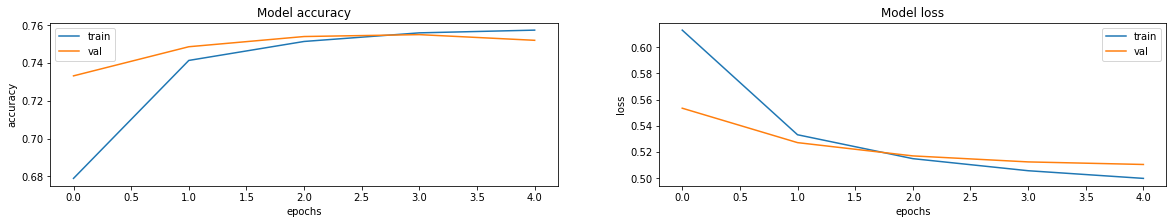

In [25]:
history = pd.read_csv(f'./models/vanilla_model_history.csv')
display_learning_curves(history)

##### Stemming

In [26]:
train_simple_nn(train_df["text_stem"].to_list(), test_df["text_stem"].to_list(), val_df["text_stem"].to_list(), "stemming")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                14170     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 14,181
Trainable params: 14,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
10000/10000 - 24s - loss: 0.6074 - accuracy: 0.6812 - val_loss: 0.5473 - val_accuracy: 0.7346
Epoch 2/5
10000/10000 - 23s - loss: 0.5285 - accuracy: 0.7443 - val_loss: 0.5187 - val_accuracy: 0.7530
Epoch 3/5
10000/10000 - 23s - loss: 0.5117 - accuracy: 0.7531 - val_loss: 0.5095 - val_accuracy: 0.7616
Epoch 4/5
10000/10000 - 23s - loss: 0.5029 - accuracy: 0.7572 - val_loss: 0.5053 - val_accuracy: 0.7638
Epoch 5/5
10000/10000 - 23s - loss: 0.4968 - accuracy: 0.7617 - val_loss: 0.5019 - val_accu

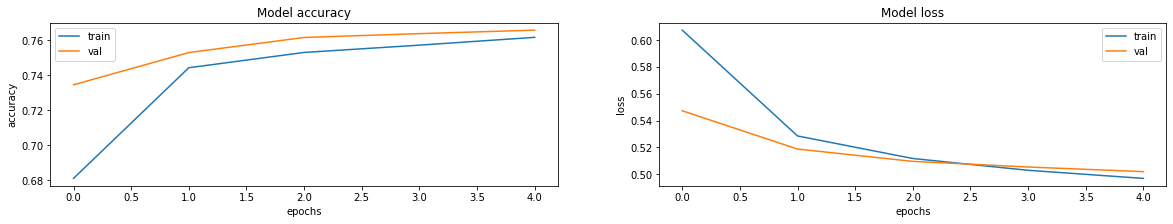

In [27]:
history = pd.read_csv(f'./models/stemming_model_history.csv')
display_learning_curves(history)

##### Lemmatization

In [28]:
train_simple_nn(train_df["text_lem"].to_list(), test_df["text_lem"].to_list(), val_df["text_lem"].to_list(), "lemmatization")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                14460     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 14,471
Trainable params: 14,471
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
10000/10000 - 24s - loss: 0.6050 - accuracy: 0.6855 - val_loss: 0.5497 - val_accuracy: 0.7348
Epoch 2/5
10000/10000 - 23s - loss: 0.5300 - accuracy: 0.7433 - val_loss: 0.5258 - val_accuracy: 0.7502
Epoch 3/5
10000/10000 - 23s - loss: 0.5129 - accuracy: 0.7518 - val_loss: 0.5176 - val_accuracy: 0.7548
Epoch 4/5
10000/10000 - 23s - loss: 0.5038 - accuracy: 0.7571 - val_loss: 0.5114 - val_accuracy: 0.7582
Epoch 5/5
10000/10000 - 23s - loss: 0.4980 - accuracy: 0.7595 - val_loss: 0.5084 - val_accu

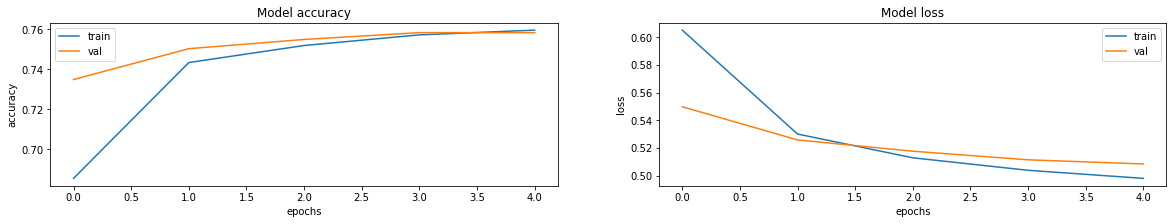

In [29]:
history = pd.read_csv(f'./models/lemmatization_model_history.csv')
display_learning_curves(history)

In [30]:
test_df.head(20)

,target,text,text_stem,text_lem,vanilla_model_label,stemming_model_label,lemmatization_model_label
0,1,thanx ff luv,thanx ff luv,thanx ff luv,0.864551,0.883379,0.895680
1,0,john one best history music wish still alive,john one best histori music wish still aliv,john one best history music wish still alive,0.349795,0.397434,0.451304
2,0,like like much,like like much,like like much,0.451873,0.539918,0.563950
3,0,wrong fav,wrong fav,wrong fav,0.360927,0.468074,0.461210
4,1,love room games,love room game hero,love room game hero,0.680602,0.825834,0.832105
5,0,im home finally still things fb,im home final still thing fb,im home finally still thing fb,0.446011,0.392610,0.501738
6,1,dad got gonna meet today hope everything goes ...,dad got gonna meet today hope everyth goe well,dad got gonna meet today hope everything go well,0.517342,0.466263,0.693338
7,0,omg someone please shoot sooo exhausted,omg someon pleas shoot sooo exhaust,omg someone please shoot sooo exhausted,0.137255,0.146280,0.149792
8,0,gonna special order shit cause miss working bo...,gonna special order shit caus miss work book s...,gonna special order shit cause miss working bo...,0.084374,0.073617,0.048287
9,1,thanks following,thank follow,thanks following,0.893128,0.948093,0.912934


In [31]:
res_df = pd.read_csv(f'./results.csv')
print(res_df.head())

      model_name  accuracy      loss
0        vanilla    0.7542  0.508852
1       stemming    0.7528  0.508107
2  lemmatization    0.7546  0.508443
3        vanilla    0.7530  0.511699
4       stemming    0.7524  0.508235


<AxesSubplot:xlabel='target', ylabel='Count'>

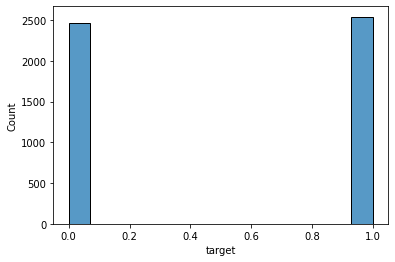

In [32]:
sns.histplot(data=train_df["target"])

#### Utilisation de modèles de plongement de mots

In [33]:
trained = 1

if not trained:
    # get train data
    X_train = train_df["text"].to_list()
    X_train_stem = train_df["text_stem"].to_list()
    X_train_lem = train_df["text_lem"].to_list()
    # get test data
    X_test = test_df["text"].to_list()
    X_test_stem = test_df["text_stem"].to_list()
    X_test_lem = test_df["text_lem"].to_list()
    # get validation data
    X_val = val_df["text"].to_list()
    X_val_stem = val_df["text_stem"].to_list()
    X_val_lem = val_df["text_lem"].to_list()
    def encoder(data_train, data_test, data_val):
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words)
        tokenizer.fit_on_texts(data_train)
        encoded_train = tokenizer.texts_to_sequences(data_train)
        encoded_test = tokenizer.texts_to_sequences(data_test)
        encoded_val = tokenizer.texts_to_sequences(data_val)
        max_len = max([len(s.split()) for s in data_train])
        train_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_train, maxlen=max_len, padding='post'))
        test_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_test, maxlen=max_len, padding='post'))
        val_data = np.asarray(tf.keras.preprocessing.sequence.pad_sequences(encoded_val, maxlen=max_len, padding='post'))

        return train_data, test_data, val_data, max_len

    X_train, X_test, X_val, vanilla_input_dim = encoder(X_train, X_test, X_val)
    X_train_stem, X_test_stem, X_val_stem, stem_input_dim = encoder(X_train_stem, X_test_stem, X_val_stem)
    X_train_lem, X_test_lem, X_val_lem, lem_input_dim = encoder(X_train_lem, X_test_lem, X_val_lem)

    # make tf datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, tf.cast(y_train, tf.int32))).shuffle(BUFFER_SIZE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, tf.cast(y_test, tf.int32)))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, tf.cast(y_val, tf.int32))).shuffle(BUFFER_SIZE)
    # preprocess datasets
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)